# Previsão de Multi-Passsos de Séries Temporais utilizando redes Long Short-Term Memory (LSTM) com Keras

### Depois de completar este tutorial, saberemos melhor como:

Fonte: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

- Preparar dados para que eles se enquadrem no formato de um problema de predição de Multi-Passos de series temporais
- Como desenvolver um modelo LSTM para predizer Multi-Passos de series temporais
- Avaliar o desempenho de predição de Multi-Passos de series temporais

# Sumário
1. Shampoo Sales Dataset
2. Preparação dos dados e Avaliação do modelo
3. Rede Multi-Passos LSTM

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from datetime import datetime
from math import sqrt

Using TensorFlow backend.


### Shampoo Sales Dataset
 - Este Dataset descreve mensalmente o valor de vendas de shampoo em um período de três anos.
 - Os valores são uma contagem das vendas e existem 36 observações. 
 - O dataset pode ser encontrado no seguinte link:
     - https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

In [2]:
# Ler Dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
df = pd.read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
df.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64

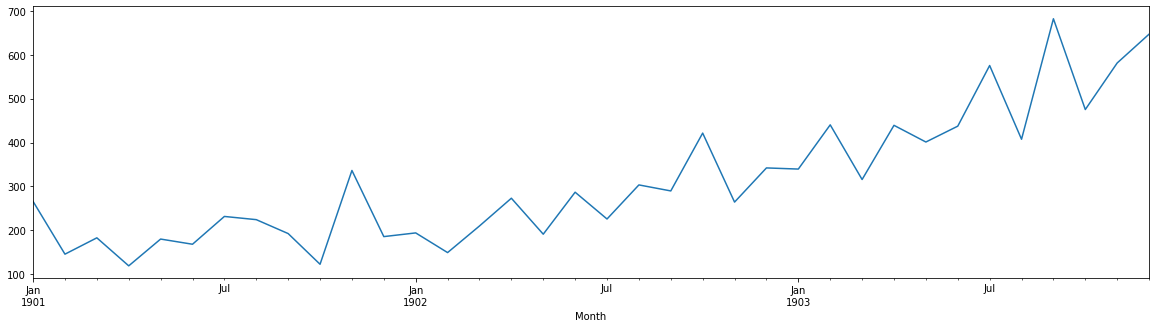

In [3]:
plt.figure(figsize=(20, 5))
df.plot()
plt.show()

### Preparação dos dados e Avaliação do modelo
#### Preparação dos dados
1. Iremos separar os dados da seguinte forma:
    - Os dois primeiros anos serão os dados de Treino
    - O ultimo ano irá compor os dados de Teste
 
2. Predição de Multi-Passos
    - Dado um mês como entrada, teremos que predizer os 3 próximos meses.
    - Expecificamente do mês de Dezembro do ano 2 até o mês de setembro do ano 3 poderemos realizar as predições e a sua respectiva avaliação de desempenho 
    
        - Dec -> Jan, Feb, Mar
        - Jan -> Feb, Mar, Apr
        - Feb -> Mar, Apr, May
        - Mar -> Apr, May, Jun
        - Apr -> May, Jun, Jul
        - May -> Jun, Jul, Aug
        - Jun -> Jul, Aug, Sep
        - Jul -> Aug, Sep, Oct
        - Aug -> Sep, Oct, Nov
        - Sep -> Oct, Nov, Dec
        
3. Iremos transformar os dados de séries temporais para um problema de aprendizado supervisionado
    - Isso é transformar de uma lista de números para uma lista de padrões de entrada e saída.
    - Podemos conseguir isso usando uma função pré-preparada chamada series_to_supervised().
    - Mais informações sobre a função:http://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python

#### Avaliação do Modelo

1. Um cenário de previsão contínua será utilizado, também chamado de validação walk-forward
    - Cada etapa do conjunto de dados de teste será percorrida uma de cada vez. Um modelo será usado para fazer uma previsão para o intervalo de tempo; em seguida, o valor real do próximo mês do conjunto de dados de testes será disponibilizado ao modelo para realizar a predição no próximo intervalo de tempo. Imitando um cenário de mundo real, onde os valores reais vão sendo disponibilidos para serem utilizados nas pŕoximas predições.
    - Será utilizado o Root Mean Squared Error (RMSE) para avaliação do modelo
    
 
 


In [4]:
# transformando de series temporais para um problema de aprendizado supervisonado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # sequencia de entrada (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # sequencia predita (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # junção
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # excluir linhas com NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Como podemos observar no método acima. O objetivo dela é criar uma sequencia de informações.
 - É utilizada a função shift do pandas para que seja concatenada uma coluna com n posições de deslocamento.
 - Dessa maneira poderemos colocar o mês de entrada (X), e os n meses de saída à frente (y)

In [5]:
raw_values = df.values
raw_values = raw_values.reshape(len(raw_values), 1)
supervised = series_to_supervised(raw_values, 1, 3)
supervised.head()

,var1(t-1),var1(t),var1(t+1),var1(t+2)
1,266.0,145.9,183.1,119.3
2,145.9,183.1,119.3,180.3
3,183.1,119.3,180.3,168.5
4,119.3,180.3,168.5,231.8
5,180.3,168.5,231.8,224.5


Dividindo dataset em treino e teste
    - Sabemos que as ultimas 10 linnhas do dataset contêm informações sobre os dados do conjunto de test

In [6]:
# Transformando series temporais em conjuntos de treino e teste de problema de aprendizado supervisonado
def prepare_data(series, n_test, n_lag, n_seq):
    # Extrair valores brutos
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # transformando em um problema de aprendizado supervisionado (X, y)
    supervised = series_to_supervised(raw_values, n_lag, n_seq)
    supervised_values = supervised.values
    # separando em conjunto de treino e conjunto de teste
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return train, test

In [7]:
train, test = prepare_data(df, 10, 1, 3)
print(test)
print('Train: %s, Test: %s' % (train.shape, test.shape))

[[342.3 339.7 440.4 315.9]
 [339.7 440.4 315.9 439.3]
 [440.4 315.9 439.3 401.3]
 [315.9 439.3 401.3 437.4]
 [439.3 401.3 437.4 575.5]
 [401.3 437.4 575.5 407.6]
 [437.4 575.5 407.6 682. ]
 [575.5 407.6 682.  475.3]
 [407.6 682.  475.3 581.3]
 [682.  475.3 581.3 646.9]]
Train: (23, 4), Test: (10, 4)


Podemos observar que:
    - O conjunto de treino compreende de Janeiro do primeiro ano até novembro do segundo  ano
    - O conjunto de teste  compreende de Dezembro do segundo ano até setembro do terceiro ano

### Rede Multi-Passos LSTM 
    - Antes de usarmos o LSTM precisamos fazer duas mudanças nos dados:
        1. Estacionário. Os dados mostram uma tendência crescente que deve ser removida por diferenciação. Utilizaremos uma função chamada difference() que transformará os valores da serie temporal em uma serie de diferenças
        2. Escala. A escala dos dados deve ser reduzida para valores entre -1 e 1 compatível com a função de ativação das unidades LSTM. Utilizaremos o MinMaxScaler do sklearn.

In [8]:
# Criar uma serie temporal de diferenças
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [9]:
# Tranformando series temporais em um problema para LSTM
def prepare_data(series, n_test, n_lag, n_seq):
    # Extrair os dados brutos
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # Transformar para ser estacionário
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # Reescalar os valores para ficar entre -1 e 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # Transformar em um problema de aprendizado supervisionado X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # Dividindo os conjuntos de treino e teste
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

In [10]:
scaler, train, test = prepare_data(df, 10, 1, 3)
print(test)
print('Train: %s, Test: %s' % (train.shape, test.shape))

[[ 0.1827063  -0.15152775  0.2779048  -0.6582831 ]
 [-0.15152775  0.2779048  -0.6582831   0.37227188]
 [ 0.2779048  -0.6582831   0.37227188 -0.2986905 ]
 [-0.6582831   0.37227188 -0.2986905   0.00935356]
 [ 0.37227188 -0.2986905   0.00935356  0.43338183]
 [-0.2986905   0.00935356  0.43338183 -0.83870297]
 [ 0.00935356  0.43338183 -0.83870297  1.        ]
 [ 0.43338183 -0.83870297  1.         -1.        ]
 [-0.83870297  1.         -1.          0.29993764]
 [ 1.         -1.          0.29993764  0.13198919]]
Train: (22, 4), Test: (10, 4)


#### Treinando o Modelo LSTM
    - Isso requer primeiro que o conjunto de dados de treinamento seja transformado de uma matriz 2D [samples, features] para uma matriz 3D [samples, timesteps, features]. Fixaremos as etapas de tempo em 1, portanto, essa alteração é direta.
    - Rede LSTM:
        - Hidden Layer LSTM 
        - Output Layer com ativação linear e 3 valores de saída
        - Função de perda utilizado é o erro quadratico médio (MSE)
        - Otimizador ADAM.
    - A rede LSTM é guarda o estado, portanto teremos que resetar o estado da rede a cada época
    - O mesmo batch size deve ser usado para treinamento e teste, e como exigimos que sejam feitas previsões em cada etapa do conjunto de dados de teste, significa o batch size deve ser 1. Um batch size igual a 1 também é chamado de aprendizado on-line, pois os pesos da rede serão atualizados durante o treinamento após cada padrão de treinamento.

In [11]:
# Treinando a rede LSTM
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # Transformando em uma matriz 3D
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # Montando a Rede
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # Realizando treinamento
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [12]:
model = fit_lstm(train, 1, 3, 1, 1500, 1)

#### Realizando as predições LSTM 

In [13]:
# Realizando uma prediçãao 
def forecast_lstm(model, X, n_batch):
    # Transformando X para o formato 3D [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # Realizando predição
    forecast = model.predict(X, batch_size=n_batch)
    # Convertendo para array
    return [x for x in forecast[0, :]]

In [14]:
# Avaliando o modelo para cada passo do dataset de teste
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # Realizando predição
        forecast = forecast_lstm(model, X, n_batch)
        # Guardando resultado
        forecasts.append(forecast)
    return forecasts

In [15]:
forecasts = make_forecasts(model, 1, train, test, 1, 3)

#### Invertendo transformações para análise dos resultados

In [16]:
# Invertendo a transformação de diferença (Estacionário)
def inverse_difference(last_ob, forecast):
    # Invertendo a previsão
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Obtendo os próximos valores a partir do primeiro valor invertido
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

In [17]:
# Transformando os valores preditos para a escala real
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # Criando um array das predições
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # Invertendo escala
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # Invertendo diferença
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # Guardando valores
        inverted.append(inv_diff)
    return inverted

In [18]:
# inverse transform forecasts and test
forecasts = inverse_transform(df, forecasts, scaler, 10+2)

In [19]:
actual = [row[1:] for row in test]
actual = inverse_transform(df, actual, scaler, 12)

In [20]:
def evaluate_forecasts(test, forecasts, n_lag=1, n_seq=3):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

In [21]:
evaluate_forecasts(actual, forecasts)

t+1 RMSE: 112.856071
t+2 RMSE: 85.443323
t+3 RMSE: 107.254584


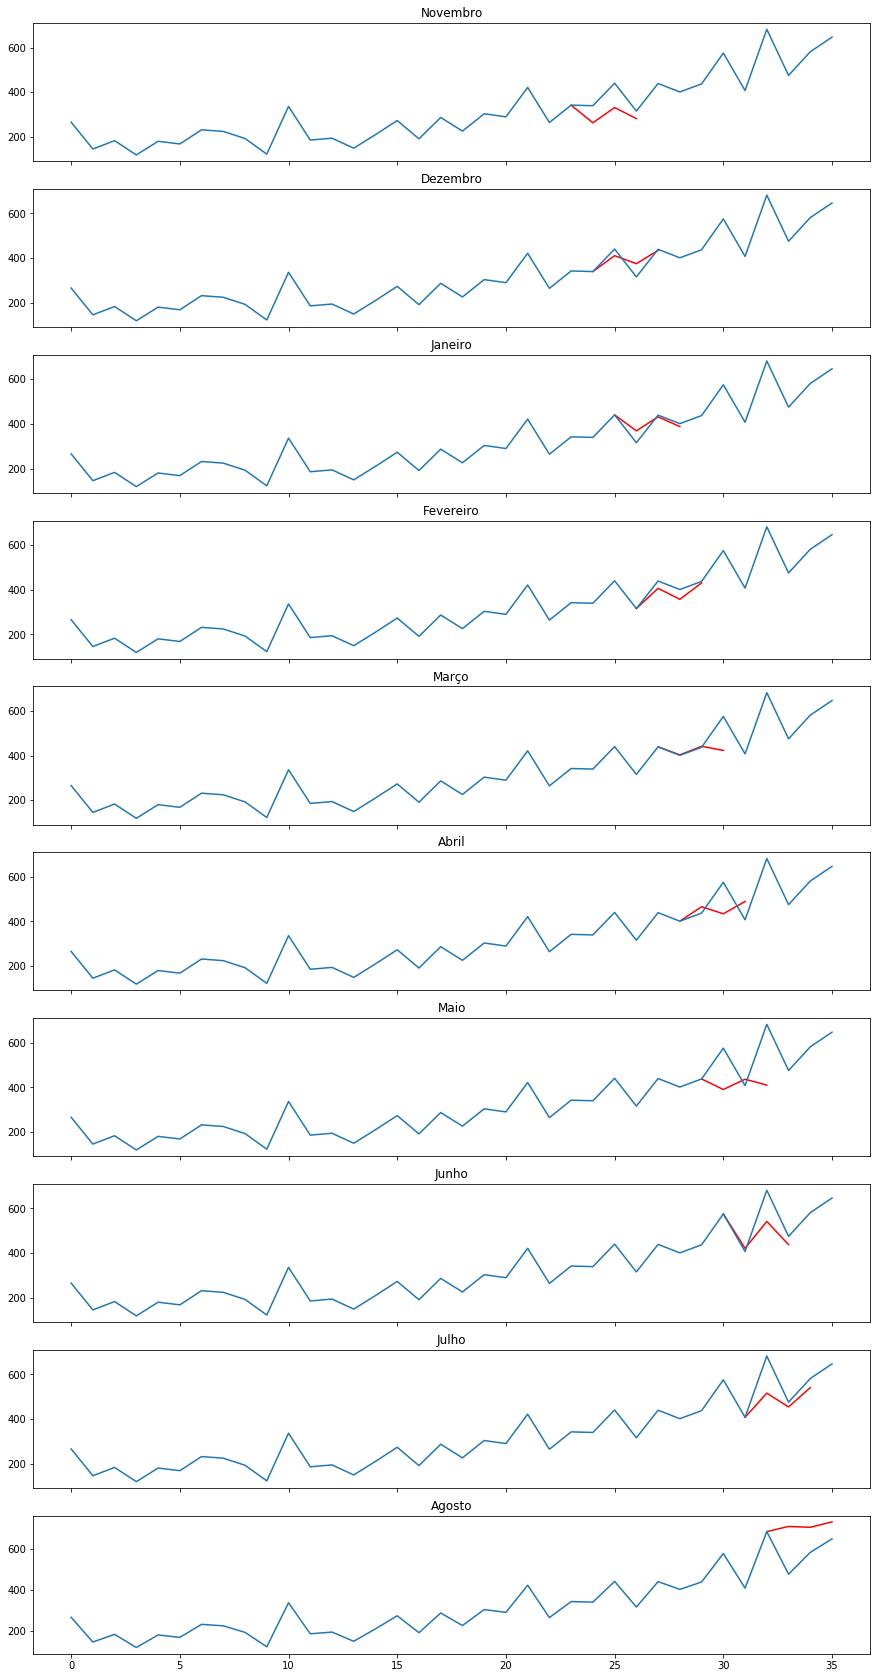

In [22]:
figure, axes = plt.subplots(len(forecasts), figsize=(15,30), sharex=True, )
meses = ['Novembro', 'Dezembro', 'Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro']
for i in range(len(forecasts)):
    off_s = len(df) - 12 + i - 1
    off_e = off_s + len(forecasts[i]) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [df.values[off_s]] + forecasts[i]
    axes[i].plot(xaxis, yaxis, color='red')
    axes[i].plot(df.values)
    axes[i].set_title(meses[i])
plt.show()